# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per capita (by Census Tract) 

### MANHATTAN

In [2]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [3]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [4]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [5]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [6]:
# look at only Brooklyn
MH_trees_cap = trees_cts.query("county == 'New York'")

[Text(0.5, 1.0, 'Manhattan')]

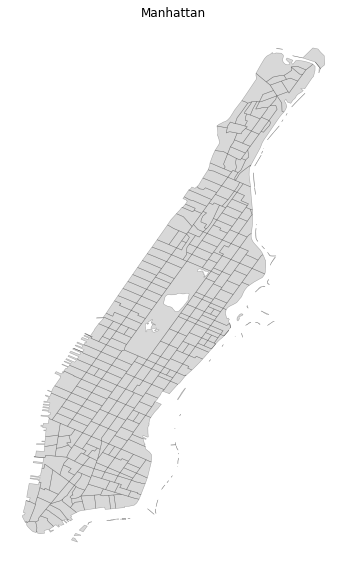

In [7]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_cap.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Manhattan')

In [8]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
MH_trees_cap = MH_trees_cap.dropna(subset = ['trees_per_capita'])

In [9]:
# drop trees per capita with 0
MH_trees_cap = MH_trees_cap.query("trees_per_capita > 0")

In [10]:
# create queen contiguity weights
w_MH = weights.Queen.from_dataframe(MH_trees_cap)

In [13]:
# fill in islands with KNN weights
w_knn_MH = weights.KNN.from_dataframe(MH_trees_cap, k=1)

In [14]:
w_MH = weights.attach_islands(w_MH, w_knn_MH)

There are no disconnected observations (no islands)!


In [15]:
# row standardize weights
w_MH.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per capita*

In [16]:
# on trees per capita
local_moran_MH = esda.moran.Moran_Local(MH_trees_cap['trees_per_capita'], w_MH)

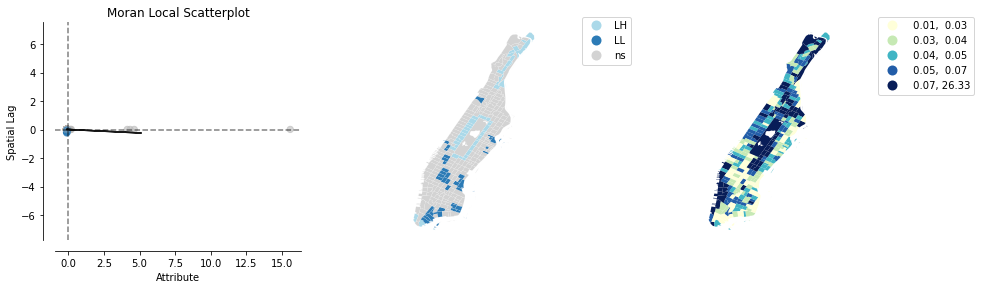

In [17]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_MH, MH_trees_cap,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Manhattan/Manhattan_Trees-per-Capita_moran.pdf")

In [18]:
# get clusters and outliers - adding columns to the DF

MH_trees_cap['local_moran_Is'] = local_moran_MH.Is
MH_trees_cap['local_moran_p_value'] = local_moran_MH.p_sim
MH_trees_cap['local_moran_quadrant'] = local_moran_MH.q

In [19]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_MH = MH_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_MH = MH_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_MH = MH_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_MH = MH_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


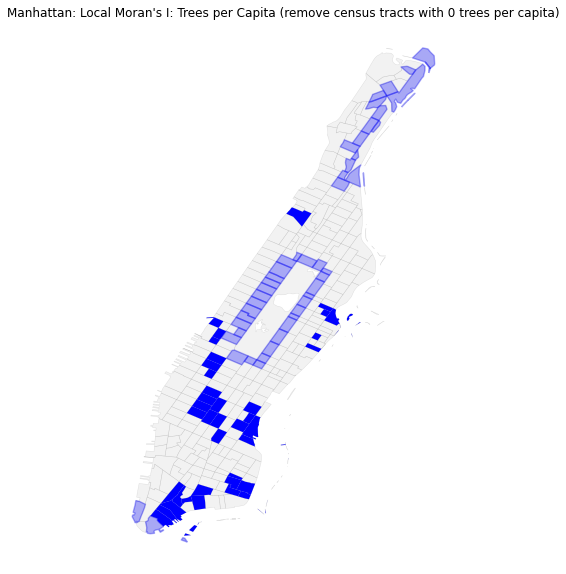

In [20]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_cap.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
MH_trees_cap.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_MH.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_MH.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_MH.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_MH.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Manhattan: Local Moran's I: Trees per Capita (remove census tracts with 0 trees per capita)")

plt.savefig("maps/Manhattan/Manhattan_Trees-per-Capita.pdf")

### *investigate the numbers*

In [50]:
# look at smallest values
MH_trees_cap['trees_per_capita'].nsmallest(n=10)

126     0.005572
1617    0.005989
629     0.006210
1660    0.007080
392     0.007991
135     0.009969
1846    0.010884
1099    0.011243
447     0.011829
1623    0.012223
Name: trees_per_capita, dtype: float64

In [32]:
# look at largest values
MH_trees_cap['trees_per_capita'].nlargest(n=10)

1588    26.333333
1854     7.982906
406      7.500000
1583     7.153846
1601     0.576850
594      0.531250
131      0.438735
1615     0.209735
1584     0.207277
1644     0.192623
Name: trees_per_capita, dtype: float64

In [23]:
# lowest 1% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.01))

0.007098214513270295


In [24]:
# lowest 5% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.05))

0.01588974384531307


In [25]:
# lowest 10% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.10))

0.021820566915503624


In [26]:
# lowest 20% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.20))

0.029412698186501076


In [27]:
# highest 1% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.99))

7.022306232666884


In [28]:
# highest 5% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.95))

0.12130711919503756


In [29]:
# highest 10% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.90))

0.09190020252510019


In [30]:
# highest 20% of data
print(MH_trees_cap['trees_per_capita'].quantile(q = 0.80))

0.06522786733197924


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 0.15 and more than 1  trees per capita*

In [30]:
# limit the range
MH_trees_cap_limit = MH_trees_cap.query("trees_per_capita > 0.0195 & trees_per_capita < 1")

In [31]:
# create queen contiguity weights
w_MH2 = weights.Queen.from_dataframe(MH_trees_cap_limit)

In [33]:
# fill in islands with KNN weights
w_knn_MH2 = weights.KNN.from_dataframe(MH_trees_cap_limit, k=1)

In [34]:
w_MH2 = weights.attach_islands(w_MH2, w_knn_MH2)

There are no disconnected observations (no islands)!


In [35]:
# row standardize weights
w_MH2.transform = 'R'

In [36]:
# on trees per capita
local_moran_MH2 = esda.moran.Moran_Local(MH_trees_cap_limit['trees_per_capita'], w_MH2)

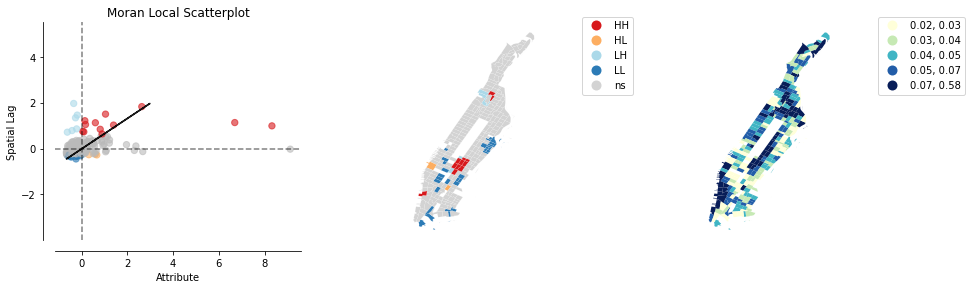

In [42]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_MH2, MH_trees_cap_limit,'trees_per_capita', p = 0.05 );

plt.savefig("maps/Manhattan/Manhattan_Trees-per-Capita_limited_moran.pdf")

In [39]:
# get clusters and outliers
MH_trees_cap_limit['local_moran_Is'] = local_moran_MH2.Is
MH_trees_cap_limit['local_moran_p_value'] = local_moran_MH2.p_sim
MH_trees_cap_limit['local_moran_quadrant'] = local_moran_MH2.q

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [40]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_MH2 = MH_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_MH2 = MH_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_MH2 = MH_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_MH2 = MH_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

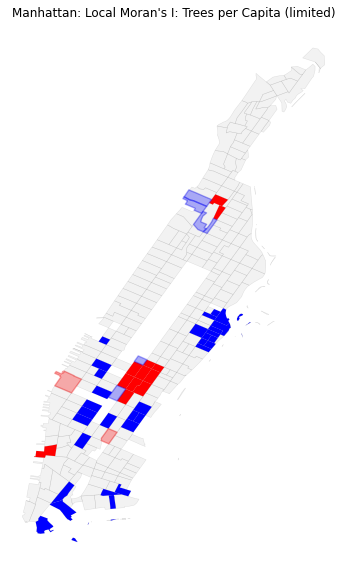

In [41]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
MH_trees_cap_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
MH_trees_cap_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_MH2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_MH2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_MH2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_MH2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Manhattan: Local Moran's I: Trees per Capita (limited)")

plt.savefig("maps/Manhattan/Manhattan_Trees-per-Capita_limited.pdf")